<a href="https://colab.research.google.com/github/HyeonhoonLee/OSAM_NLP/blob/master/BERT_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. EDA

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd
import sklearn 
from sklearn import model_selection
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [3]:
# randsom seed
seed=1234
np.random.seed(seed)

In [4]:
num_classes=32

In [5]:
DATA_IN_PATH = '/content/drive/My Drive/DataCollection/OSAM/'

In [6]:
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
    if 'csv' in file :
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기 : 
combined.csv                  6.62MB


In [7]:
#loading csv data
all_data = pd.read_csv(DATA_IN_PATH + 'combined.csv', quoting = 2)
all_data.head()

,symptom,class
0,질문하겠습니다. 이어폰을 음량을 0으로 하고 끼고만 있어도 귀에 안 좋나요?,FM
1,독감예방주사,FM
2,목에 음식물 그대로 끼어서 계속 이물감이 있습니다,FM
3,케겔운동 궁금한것,FM
4,등 통증 관련문의,FM


In [8]:
# all_data의 전체 길이
len(all_data)

118087

In [9]:
#stratififed split to train_data, test_data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_idx, test_idx in split.split(all_data, all_data["class"]):
    train_data = all_data.loc[train_idx]
    test_data = all_data.loc[test_idx]

In [10]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))
print('전체 학습데이터의 개수: {}'.format(len(test_data)))

전체 학습데이터의 개수: 94469
전체 학습데이터의 개수: 23618


In [11]:
train_length = train_data['symptom'].astype(str).apply(len)

In [12]:
train_length.head()

48994    16
77552    25
69473    18
4200      5
2506     25
Name: symptom, dtype: int64

Text(0, 0.5, 'Number of symptom')

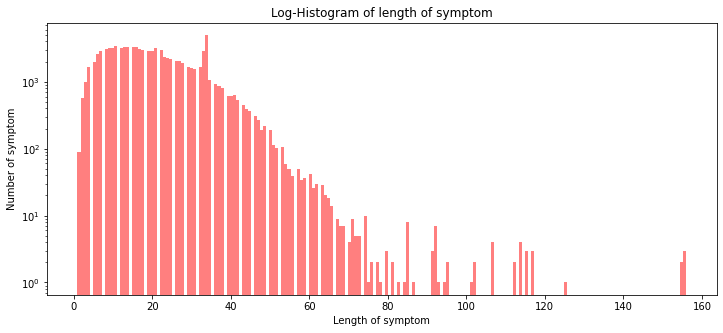

In [13]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_length, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of length of symptom')
# 그래프 x 축 라벨
plt.xlabel('Length of symptom')
# 그래프 y 축 라벨
plt.ylabel('Number of symptom')

In [14]:
print('증상 길이 최대 값: {}'.format(np.max(train_length)))
print('증상 길이 최소 값: {}'.format(np.min(train_length)))
print('증상 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('증상 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('증상 길이 중간 값: {}'.format(np.median(train_length)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('증상 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('증상 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

증상 길이 최대 값: 156
증상 길이 최소 값: 1
증상 길이 평균 값: 20.51
증상 길이 표준편차: 11.35
증상 길이 중간 값: 19.0
증상 길이 제 1 사분위: 12.0
증상 길이 제 3 사분위: 28.0


{'boxes': [<matplotlib.lines.Line2D at 0x7efcb3cd6cf8>],
 'caps': [<matplotlib.lines.Line2D at 0x7efcb3c90748>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efcb3c9a550>],
 'means': [<matplotlib.lines.Line2D at 0x7efcb3c9a208>],
 'medians': [<matplotlib.lines.Line2D at 0x7efcb3c90e48>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7efcb3c90048>,
  <matplotlib.lines.Line2D at 0x7efcb3c903c8>]}

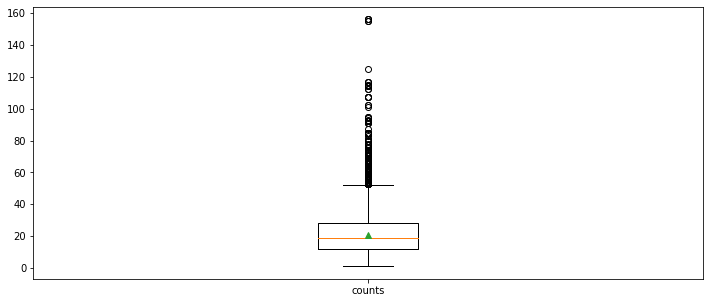

In [15]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(train_length,
             labels=['counts'],
             showmeans=True)

In [16]:
# 보통은 문자열이 아닌 데이터는 삭제하나, 증상의 경우 발열, 체중 등과 같은 내용이 중요하므로 숫자도 살려둔다.
# train_review = [review for review in train_data['document'] if type(review) is str]
train_symptom = [symptom for symptom in train_data['symptom'] if type(symptom) is (str or int or float)]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


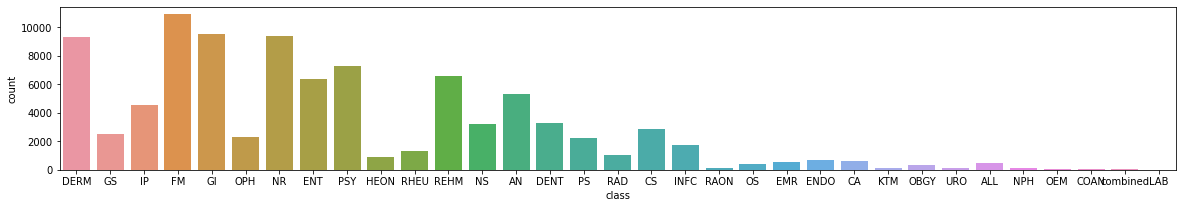

In [17]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(20, 3)
sns.countplot(train_data['class'])

In [20]:
# 이게 왜 생겼는지는 모르겠지만....삭제.
train_data = train_data[train_data["class"]!="combined"]
print(len(train_data))
test_data = test_data[test_data["class"]!="combined"]
print(len(test_data))

94443
23611


In [21]:
# severe imbalenced data가 확인되지만 real-world로 반영한다고 생각하고 그대로 진행한다.
# 단, FM(가정의학과)의 비중이 너무 높고 오히려 OS 비중이 낮은 것은 본 프로젝트가 군인 대상인 점을 감안하여 조정이 필요할 것 같다.
for i in range(num_classes):
  print("증상 개수: {}".format(train_data['class'].value_counts()[i]))

증상 개수: 10911
증상 개수: 9525
증상 개수: 9415
증상 개수: 9353
증상 개수: 7264
증상 개수: 6592
증상 개수: 6386
증상 개수: 5333
증상 개수: 4524
증상 개수: 3296
증상 개수: 3209
증상 개수: 2844
증상 개수: 2492
증상 개수: 2338
증상 개수: 2250
증상 개수: 1736
증상 개수: 1352
증상 개수: 1015
증상 개수: 922
증상 개수: 668
증상 개수: 606
증상 개수: 534
증상 개수: 506
증상 개수: 374
증상 개수: 350
증상 개수: 156
증상 개수: 149
증상 개수: 123
증상 개수: 97
증상 개수: 57
증상 개수: 57
증상 개수: 9


In [22]:
# 각 증상 서술의 단어 수를 확인.
# 데이터를 띄어쓰기 기준으로 나눠서 그 개수를 하나의 변수로 할당한다.
train_word_counts = train_data['symptom'].astype(str).apply(lambda x:len(x.split(' ')))

Text(0, 0.5, 'Number of symptom')

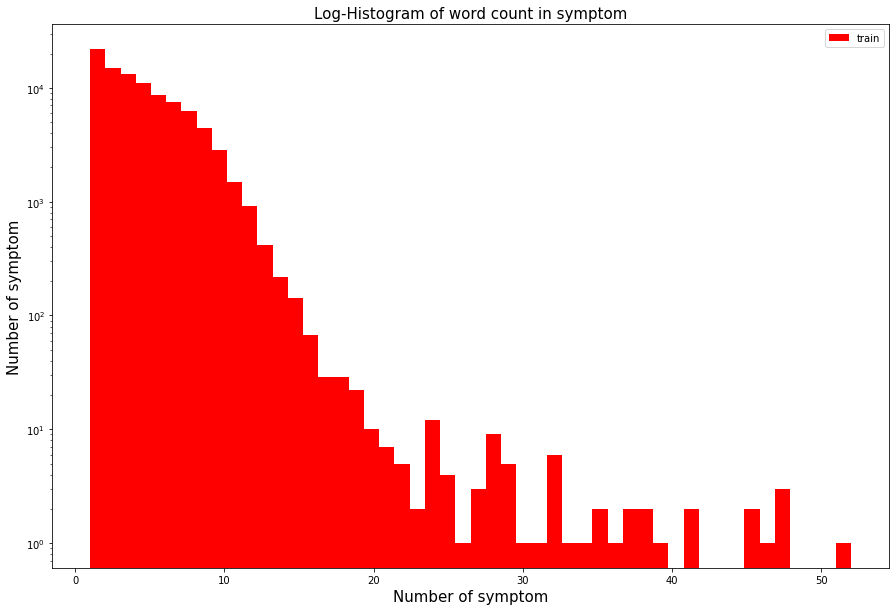

In [23]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in symptom', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of symptom', fontsize=15)
plt.ylabel('Number of symptom', fontsize=15)

In [24]:
print('증상 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('증상 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('증상 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('증상 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('증상 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('증상 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('증상 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

증상 단어 개수 최대 값: 52
증상 단어 개수 최소 값: 1
증상 단어 개수 평균 값: 4.82
증상 단어 개수 표준편차: 2.90
증상 단어 개수 중간 값: 4.0
증상 단어 개수 제 1 사분위: 3.0
증상 단어 개수 제 3 사분위: 7.0


In [25]:
# 특수문자 확인하기
qmarks = np.mean(train_data['symptom'].astype(str).apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_data['symptom'].astype(str).apply(lambda x: '.' in x)) # 마침표
                  
print('물음표가있는 질문: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop * 100))

물음표가있는 질문: 20.85%
마침표가 있는 질문: 29.94%


## 2. BERT를 이용한 fine tuning

In [26]:
# installing transforemrs
!pip install transformers

     |████████████████████████████████| 1.1MB 2.8MB/s 
     |████████████████████████████████| 1.1MB 12.4MB/s 
     |████████████████████████████████| 3.0MB 18.4MB/s 
     |████████████████████████████████| 890kB 42.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b24edda7aedbe936a83ba3445f39ce2606bca75f631b6b1e794d707c76819380
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [27]:
import re
from tqdm import tqdm

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [30]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
# VALID_SPLIT = 0.2  ## 이미 validation split함.
MAX_LEN = 7# EDA에서 3사분위 수가 7이었음.
DATA_IN_PATH = '/content/drive/My Drive/DataCollection/OSAM/'
DATA_OUT_PATH = '/content/drive/My Drive/DataCollection/OSAM/'

In [31]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

## 토크나이저 테스트

In [32]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 하', '# # 세', '# # 요', ',', '반', '# # 갑', '# # 습', '# # 니 다', '.', '[ S E P ]']


In [33]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


### Symptom to Specialty Classification (SSC)

In [34]:
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


In [35]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [ ]:
# train_data = train_data[:1000] # for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["document"], train_data["label"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass
## check.... movie to symptom 
train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

100%|██████████| 149995/149995 [01:02<00:00, 2399.97it/s]


# sents: 149995, # labels: 149995


In [ ]:
# 최대 길이: 39
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[  101  1181 49904 13503   119   119   119  1180 29347 63227 27884 12300
  1177 29347 47087 13045 30666 18539 18702 12397   119   119   119   119
  1174 29347 40523 25763 13130 20766 23724 20966 97076 46069 17360 12799
  1174 25539   102]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] 흠... 포스터보고 초딩영화줄.... 오버연기조차 가볍지 아 [SEP]


In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

In [ ]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

data_out/KOR/tf2_bert_naver_movie -- Folder already exists 

Train on 119996 samples, validate on 29999 samples
Epoch 1/3
119808/119996 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.7908
Epoch 00001: val_accuracy improved from -inf to 0.84816, saving model to data_out/KOR/tf2_bert_naver_movie/weights.h5
119996/119996 [==============================] - 354s 3ms/sample - loss: 0.4311 - accuracy: 0.7909 - val_loss: 0.3446 - val_accuracy: 0.8482
Epoch 2/3
119808/119996 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8565
Epoch 00002: val_accuracy improved from 0.84816 to 0.86220, saving model to data_out/KOR/tf2_bert_naver_movie/weights.h5
119996/119996 [==============================] - 334s 3ms/sample - loss: 0.3258 - accuracy: 0.8565 - val_loss: 0.3240 - val_accuracy: 0.8622
Epoch 3/3
119808/119996 [============================>.] - ETA: 0s - loss: 0.2797 - accuracy: 0.8796
Epoch 00003: val_accuracy improved from 0.86220 to 0.86390, savi

In [ ]:
plot_graphs(history, 'loss')

# Korean Movie Review Test 데이터

In [ ]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

49997it [00:20, 2402.33it/s]


num sents, labels 49997, 49997


In [ ]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49997/49997 [==============================] - 41s 823us/sample - loss: 0.3375 - accuracy: 0.8593
test loss, test acc:  [0.3374919870977371, 0.8592716]
